In [1]:
# import libraries
import os
import tarfile
import random
import gc
import warnings
import itertools

import numpy as np
import pandas as pd

import cv2
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, LeakyReLU, ReLU
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import Callback,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model


from sklearn.model_selection import train_test_split
from sklearn.metrics import  plot_confusion_matrix,classification_report,roc_auc_score, average_precision_score

warnings.filterwarnings('ignore')


In [2]:
# import dataset
df_train = pd.read_csv('../input/140k-real-and-fake-faces/train.csv',index_col=0)
df_val = pd.read_csv('../input/140k-real-and-fake-faces/valid.csv',index_col=0)
df_test = pd.read_csv('../input/140k-real-and-fake-faces/test.csv',index_col=0)

In [3]:
df_train.head()

,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31355,1,real,train/real/31355.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,02884,1,real,train/real/02884.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,33988,1,real,train/real/33988.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,53875,1,real,train/real/53875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24149,1,real,train/real/24149.jpg


In [4]:
df_val.head()

,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,20001,1,real,valid/real/20001.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,11264,1,real,valid/real/11264.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,19817,1,real,valid/real/19817.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,46851,1,real,valid/real/46851.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,10411,1,real,valid/real/10411.jpg


In [5]:
df_test.head()

,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,18233,1,real,test/real/18233.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,54317,1,real,test/real/54317.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,40155,1,real,test/real/40155.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,12875,1,real,test/real/12875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,52543,1,real,test/real/52543.jpg


In [6]:
# remove not needed columns and shuffle
df_train = df_train.drop(columns=['original_path','id','label_str']).sample(frac=1)
df_val = df_val.drop(columns=['original_path','id','label_str']).sample(frac=1)
df_test = df_test.drop(columns=['original_path','id','label_str']).sample(frac=1)

# rectify labels
df_train['label'] = 1 - df_train['label']
df_val['label'] = 1 - df_val['label']
df_test['label'] = 1 - df_test['label']

In [7]:
# split datasets by columns
y_train = df_train['label']
X_train = df_train['path']

y_val = df_val['label']
X_val = df_val['path']

y_test = df_test['label']
X_test = df_test['path']

<BarContainer object of 2 artists>

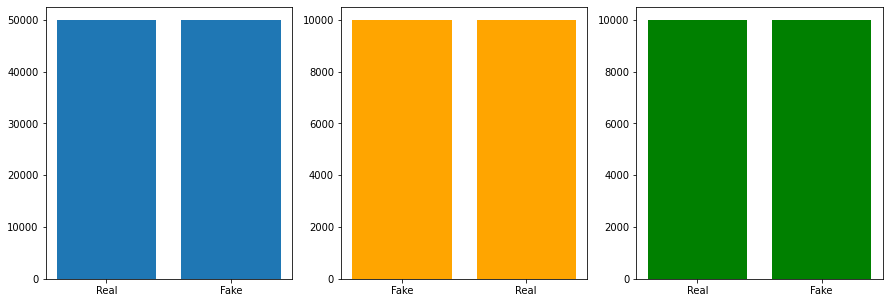

In [8]:
# Check class balance for each dataset
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].bar(y_train.value_counts().index, y_train.value_counts(), tick_label=['Real','Fake'])
axs[1].bar(y_val.value_counts().index, y_val.value_counts(), tick_label=['Real','Fake'], color='orange')
axs[2].bar(y_test.value_counts().index, y_test.value_counts(), tick_label=['Real','Fake'], color='green')

<BarContainer object of 2 artists>

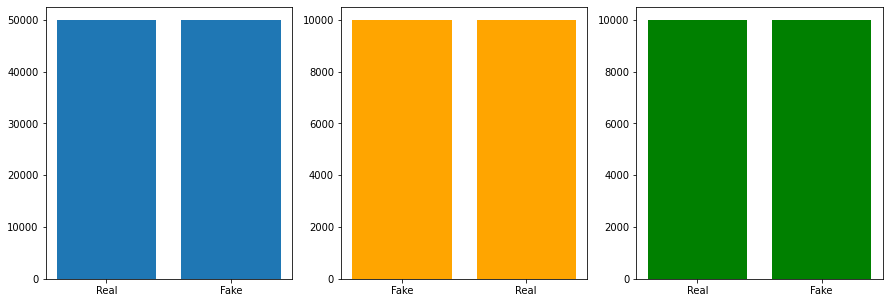

In [9]:
# Check for class balance in extracted data
fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].bar(y_train.value_counts().index, y_train.value_counts(), tick_label=['Real','Fake'])
axs[1].bar(y_val.value_counts().index, y_val.value_counts(), tick_label=['Real','Fake'], color='orange')
axs[2].bar(y_test.value_counts().index, y_test.value_counts(), tick_label=['Real','Fake'], color='green')

In [10]:
# map each image name to its path
X_train = X_train.map(lambda x: '../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/' + x)
X_val = X_val.map(lambda x: '../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/' + x)
X_test = X_test.map(lambda x: '../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/' + x)

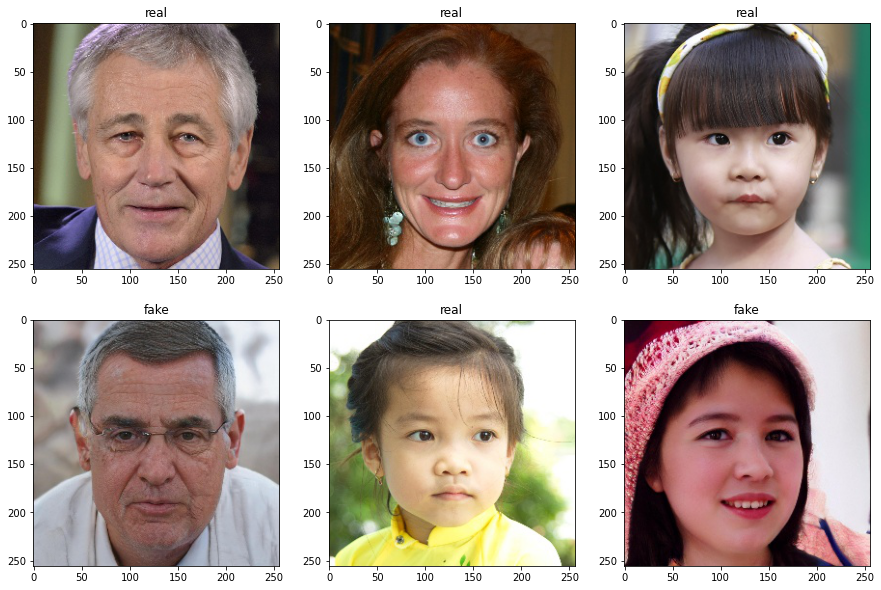

In [11]:
# show a sample of images from the dataset with corresponding labels
label_arg = {0:'real', 1:'fake'}
fig, axs = plt.subplots(2,3,figsize=(15,10))
for i in range(2):
    for j in range(3):
        random_idx = np.random.randint(0,X_train.shape[0],1)
        img = Image.open(X_train.iloc[int(random_idx)])
        label = y_train.iloc[int(random_idx)]
        axs[i,j].imshow(img)
        axs[i,j].set_title(label_arg[label])

# Preprocessing

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
ig = ImageDataGenerator(rescale=1./255.)
base_path = '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/'
train_flow = ig.flow_from_directory(
    base_path + 'train/',
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical'
)

ig1 = ImageDataGenerator(rescale=1./255.)

valid_flow = ig1.flow_from_directory(
    base_path + 'valid/',
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical'
)

test_flow = ig.flow_from_directory(
    base_path + 'test/',
    target_size=(128, 128),
    batch_size=1,
    shuffle = False,
    class_mode='categorical'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


# CNN Architecture 

In [13]:
from functools import partial

tf.random.set_seed(42) 
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[128, 128, 3]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation="relu"),
    tf.keras.layers.Dense(units=1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
flatten (Flatten)            (None, 524288)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                33554496  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 33,637,889
Trainable params: 33,637,889
Non-trainable params: 0
____________________________________________

In [14]:
history = model.fit(train_flow, epochs=10,batch_size=64,
                    validation_data= valid_flow)

Epoch 1/10
1563/1563 [==============================] - 842s 532ms/step - loss: 0.9037 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/10
1563/1563 [==============================] - 378s 242ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/10
1563/1563 [==============================] - 349s 223ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/10
1563/1563 [==============================] - 346s 221ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/10
1563/1563 [==============================] - 326s 209ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/10
1563/1563 [==============================] - 327s 209ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/10
1563/1563 [==============================] - 341s 218ms/step - loss: 0.6932 - accuracy: 0.5000 - val_

# Using Pretrained Model ResNet50 

In [15]:
from tensorflow.keras.applications import ResNet50

pretrained = ResNet50(weights='imagenet',include_top=False,input_shape=(128,128,3))
model = tf.keras.Sequential([pretrained, 
                            tf.keras.layers.GlobalAveragePooling2D(),
                            tf.keras.layers.Dense(units=512, activation="relu"),
                            tf.keras.layers.Dense(units=2, activation="softmax")
                            ])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 24,637,826
Trainable params: 24,584,706
Non-trainable params: 53,120
_________________________________________________________________


In [16]:
history = model.fit(train_flow,
    epochs = 10,
    validation_data =valid_flow,
   callbacks= [es])

Epoch 1/10
1563/1563 [==============================] - 499s 308ms/step - loss: 0.1834 - accuracy: 0.9260 - val_loss: 0.2026 - val_accuracy: 0.9168
Epoch 2/10
1563/1563 [==============================] - 493s 315ms/step - loss: 0.0790 - accuracy: 0.9706 - val_loss: 0.2115 - val_accuracy: 0.9180
Epoch 3/10
1563/1563 [==============================] - 470s 300ms/step - loss: 0.0533 - accuracy: 0.9801 - val_loss: 0.2391 - val_accuracy: 0.9237
Epoch 4/10
1563/1563 [==============================] - 473s 303ms/step - loss: 0.0421 - accuracy: 0.9843 - val_loss: 0.1118 - val_accuracy: 0.9580
Epoch 5/10
1563/1563 [==============================] - 477s 305ms/step - loss: 0.0332 - accuracy: 0.9875 - val_loss: 0.1765 - val_accuracy: 0.9390
Epoch 6/10
1563/1563 [==============================] - 482s 308ms/step - loss: 0.0288 - accuracy: 0.9893 - val_loss: 2.3517 - val_accuracy: 0.6445
Epoch 7/10
1563/1563 [==============================] - 469s 300ms/step - loss: 0.0251 - accuracy: 0.9908 - val_

## Results

Text(0.5, 1.0, 'Accuracy')

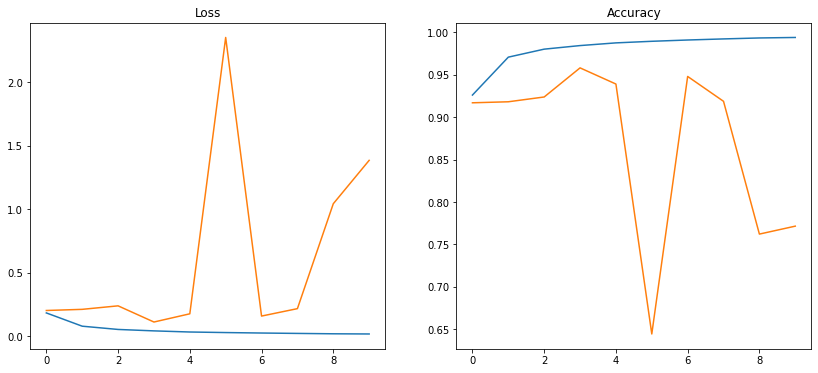

In [17]:
# plot loss and accuracy evolution
fig = plt.figure(figsize=(14,6))
ax1 = plt.subplot(121)
ax1.plot(range(len(history.history['loss'])),history.history['loss'])
ax1.plot(range(len(history.history['val_loss'])), history.history['val_loss'])
ax1.set_title('Loss')
ax2 = plt.subplot(122)
ax2.plot(range(len(history.history['accuracy'])), history.history['accuracy'])
ax2.plot(range(len(history.history['val_accuracy'])),history.history['val_accuracy'])
ax2.set_title('Accuracy')

In [18]:
y_pred = model.predict(test_flow)

In [19]:
y_pred_labels = np.argmax(y_pred, axis=1)

# Classification Report

In [20]:
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_labels))
print("AP Score:", average_precision_score(y_test, y_pred_labels))
print()
print(classification_report(y_test, y_pred_labels))

ROC AUC Score: 0.5033
AP Score: 0.5016575248756219

              precision    recall  f1-score   support

           0       0.51      0.28      0.36     10000
           1       0.50      0.73      0.59     10000

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.48     20000
weighted avg       0.50      0.50      0.48     20000

